In [60]:
import pandas as pd 
import numpy as np
from time import time
import seaborn as sns

In [61]:
import scikitplot as skplt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import preprocessing

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from matplotlib import pyplot

import sys
import warnings
warnings.filterwarnings("ignore")

## Dataset

In this section we import our dataset (already processed and encoded) and check for correlated variables

The features we are interested in have to be as independent as possible from each other. Therefore, we are going to
make sure that we don't have any correlated columns with a value higher than .95

In [62]:
#dataset_original = pd.read_csv(r'..\reports\provisional.csv', index_col = 0)
dataset_original = pd.read_csv(r'Definitive_ML_Data.csv', index_col = 0)
dataset_original = dataset_original.dropna()
dataset = dataset_original.copy()

In [63]:
dataset

,Away_team,division,matchday,result_home,season,team,GD_home,Pts_difference,home_rank
1,Arenas Club,1,1,W,1928-1929,Athletic Madrid,0.0,3.0,4
2,Real Unión,1,1,W,1928-1929,Espanyol,0.0,3.0,3
4,Catalunya,1,1,W,1928-1929,Real Madrid,0.0,3.0,1
1,Athletic,1,1,T,1928-1929,Donostia,0.0,-2.0,5
2,Racing,1,1,W,1928-1929,Barcelona,0.0,3.0,2
...,...,...,...,...,...,...,...,...,...
47993,Ponferradina,2,3,L,2021-2022,Girona,2.0,0.0,13
47997,SD Amorebieta,2,3,L,2021-2022,UD Almería,3.0,5.0,5
47992,Real Valladolid,2,3,L,2021-2022,CD Lugo,0.0,-5.0,17
47992,Real Sociedad B,2,3,T,2021-2022,CF Fuenlabrada,1.0,0.0,12


In [64]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

categorical_variables = ["season", "team", "Away_team", "result_home"]

for col in categorical_variables:
    dataset[f"{col}_encoded"] = le.fit_transform(dataset[col])

In [65]:
dataset = dataset.drop(['result_home'], axis=1)
dataset

,Away_team,division,matchday,season,team,GD_home,Pts_difference,home_rank,season_encoded,team_encoded,Away_team_encoded,result_home_encoded
1,Arenas Club,1,1,1928-1929,Athletic Madrid,0.0,3.0,4,0,12,7,2
2,Real Unión,1,1,1928-1929,Espanyol,0.0,3.0,3,0,68,115,2
4,Catalunya,1,1,1928-1929,Real Madrid,0.0,3.0,1,0,110,56,2
1,Athletic,1,1,1928-1929,Donostia,0.0,-2.0,5,0,66,11,1
2,Racing,1,1,1928-1929,Barcelona,0.0,3.0,2,0,23,102,2
...,...,...,...,...,...,...,...,...,...,...,...,...
47993,Ponferradina,2,3,2021-2022,Girona,2.0,0.0,13,90,75,96,0
47997,SD Amorebieta,2,3,2021-2022,UD Almería,3.0,5.0,5,90,136,120,0
47992,Real Valladolid,2,3,2021-2022,CD Lugo,0.0,-5.0,17,90,36,116,0
47992,Real Sociedad B,2,3,2021-2022,CF Fuenlabrada,1.0,0.0,12,90,49,114,1


In [66]:
cor_matrix = dataset.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(); print(to_drop)  



[]


<AxesSubplot:>

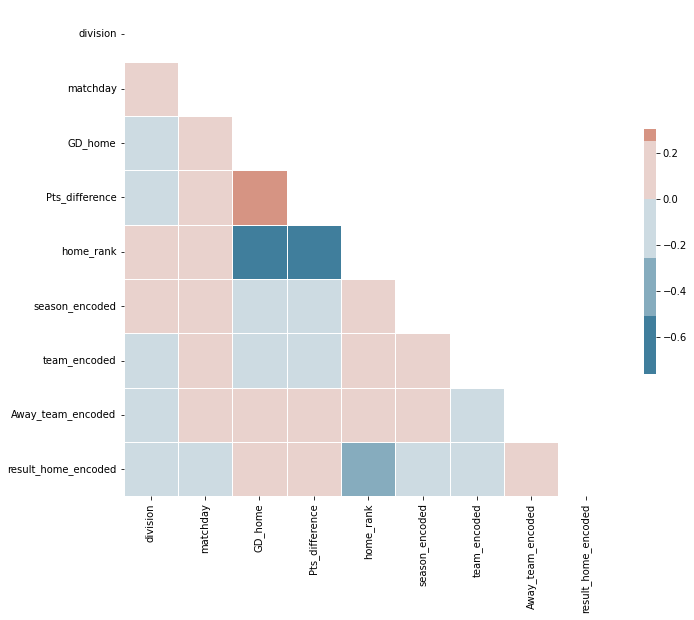

In [67]:
# Compute the correlation matrix
corr = dataset.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=False)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Normal selection of variables and splitting data

In [69]:
dataset = dataset.dropna()
target = dataset.result_home_encoded
X = dataset.loc[:, dataset.columns != 'result_home_encoded']
#X = dataset[['season','division','matchday','team','Away_team','W','GD_cum_before','rank_before']]
X_train,X_test,y_train,y_test = train_test_split(X, target, test_size=0.2, random_state=1, stratify=target)

## Function to construct confusion matrix and ROC

In [70]:
#plot our results
def confusion_matrix(trained_model, y_test, X_test):
    Y_test_pred = trained_model.predict(X_test)

    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(121)
    skplt.metrics.plot_confusion_matrix(y_test, Y_test_pred,
                                        title="Confusion Matrix",
                                        cmap="Oranges",
                                        ax=ax1)

    ax2 = fig.add_subplot(122)
    skplt.metrics.plot_confusion_matrix(y_test, Y_test_pred,
                                        normalize=True,
                                        title="Confusion Matrix",
                                        cmap="Purples",
                                        ax=ax2)

def ROC_PRC_matrix(trained_model, y_test, X_test):    
    y_test_probs = trained_model.predict_proba(X_test)
    
    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(121)
    skplt.metrics.plot_roc_curve(y_test, y_test_probs,
                       title="Digits ROC Curve", figsize=(12,6), ax=ax1)
    
    ax2 = fig.add_subplot(122)
    skplt.metrics.plot_precision_recall_curve(y_test, y_test_probs,
                        title="Digits Precision-Recall Curve", figsize=(12,6), ax= ax2)

## Estimations of parameters in models

In [71]:
# Looking for best parameter for logistic regression model
for C in [0.001, 0.01, 0.1, 1, 10, 100]:
    logreg = LogisticRegression(C=C).fit(X_train, y_train)
    prediction_in = logreg.predict(X_train)
    accuracy_r2_in = r2_score(y_train, prediction_in)
    prediction_out = logreg.predict(X_test)
    accuracy_r2_out = r2_score(y_test, prediction_out)
    print() 
    print("Logistic Regression with parameter ", C) 
    print("-" * 20)
    print("Accuracy on training set: ",logreg.score(X_train, y_train), "\tR2 training set: ", accuracy_r2_in )
    print("Accuracy on test set: ",logreg.score(X_test, y_test), "\tR2 test set: ", accuracy_r2_out )


ValueError: could not convert string to float: 'Real Oviedo'

In [26]:
# Preprunning for decision tree model, avoiding overfitting
for depth in range(3,8):
    tree = DecisionTreeClassifier(max_depth=depth).fit(X_train, y_train)
    prediction_in = tree.predict(X_train)
    accuracy_r2_in = r2_score(y_train, prediction_in)
    prediction_out = tree.predict(X_test)
    accuracy_r2_out = r2_score(y_test, prediction_out)
    print() 
    print("Decision tree with depth ", depth) 
    print("-" * 20)
    print("Accuracy on training set: ",tree.score(X_train, y_train), "\tR2 training set: ", accuracy_r2_in )
    print("Accuracy on test set: ",tree.score(X_test, y_test), "\tR2 test set: ", accuracy_r2_out )



Decision tree with depth  3
--------------------
Accuracy on training set:  0.40746630727762806 	R2 training set:  -1.1532107448338031
Accuracy on test set:  0.40459249676584735 	R2 test set:  -1.1686957877080815

Decision tree with depth  4
--------------------
Accuracy on training set:  0.41099730458221023 	R2 training set:  -1.1342224844788231
Accuracy on test set:  0.4038378611470461 	R2 test set:  -1.1727537589761803

Decision tree with depth  5
--------------------
Accuracy on training set:  0.41838274932614555 	R2 training set:  -1.0946152925551718
Accuracy on test set:  0.41073738680465716 	R2 test set:  -1.1356523073821365

Decision tree with depth  6
--------------------
Accuracy on training set:  0.42479784366576817 	R2 training set:  -1.0546819663887828
Accuracy on test set:  0.41591203104786545 	R2 test set:  -1.0891305653442926

Decision tree with depth  7
--------------------
Accuracy on training set:  0.43223719676549865 	R2 training set:  -1.0152197230174598
Accuracy 

In [27]:
# Random forest model

# We set max_depth = 5 as preprunning parameter
# We set max_features as sqrt of n_features to reduce overfitting (pag 102)

for trees in range(5,10):
    for depth in range(2,6):
        random_forest = RandomForestClassifier(max_depth=depth, n_estimators=trees, max_features=3).fit(X_train, y_train)
        prediction_in = random_forest.predict(X_train)
        accuracy_r2_in = r2_score(y_train, prediction_in)
        prediction_out = random_forest.predict(X_test)
        accuracy_r2_out = r2_score(y_test, prediction_out)
        print() 
        print(f"Random_forest with {trees} trees and {depth} depth") 
        print("-" * 40)
        print("Accuracy on training set: ",random_forest.score(X_train, y_train), "\tR2 training set: ", accuracy_r2_in )
        print("Accuracy on test set: ",random_forest.score(X_test, y_test), "\tR2 test set: ", accuracy_r2_out )



Random_forest with 5 trees and 2 depth
----------------------------------------
Accuracy on training set:  0.40897574123989217 	R2 training set:  -1.1450936259034297
Accuracy on test set:  0.4098749460974558 	R2 test set:  -1.140289988831392

Random_forest with 5 trees and 3 depth
----------------------------------------
Accuracy on training set:  0.41706199460916443 	R2 training set:  -1.1016090602050022
Accuracy on test set:  0.4156964208710651 	R2 test set:  -1.1089856390489174

Random_forest with 5 trees and 4 depth
----------------------------------------
Accuracy on training set:  0.41881401617250674 	R2 training set:  -1.0921874043036763
Accuracy on test set:  0.41634325140146616 	R2 test set:  -1.1055073779619762

Random_forest with 5 trees and 5 depth
----------------------------------------
Accuracy on training set:  0.4192991913746631 	R2 training set:  -1.0899044646045088
Accuracy on test set:  0.4127856834842605 	R2 test set:  -1.1228986833966839

Random_forest with 6 tre

As we can see, the best results are obtained for the following metrics: 
- Random Forest with 7 trees and 5 depth
- Logistic Regression with the parameter 0.01
- Decision Tree with deph 7

Now we will decide which one to choose. 


Logistic Regression
--------------------
Accuracy on training set:  0.41380053908355796
Accuracy on test set:  0.4169900819318672

Decision Tree
--------------------
Accuracy on training set:  0.43223719676549865
Accuracy on test set:  0.41623544631306597

Random Forest
--------------------
Accuracy on training set:  0.42595687331536386
Accuracy on test set:  0.42238033635187583


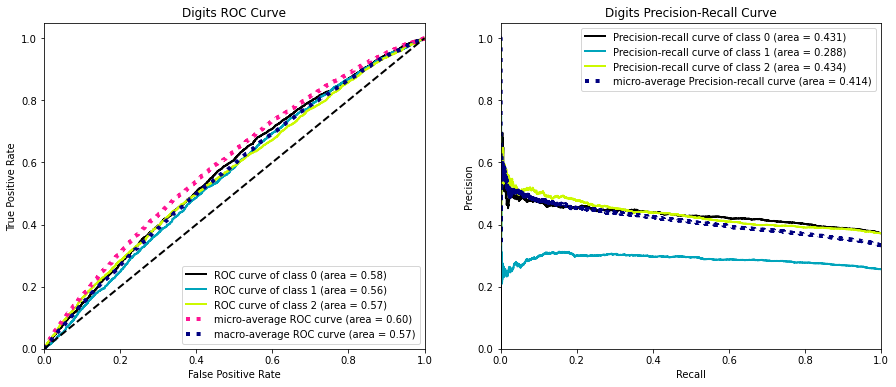

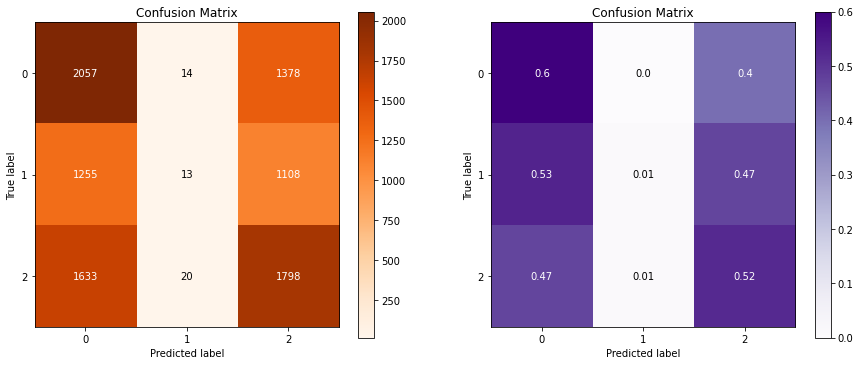

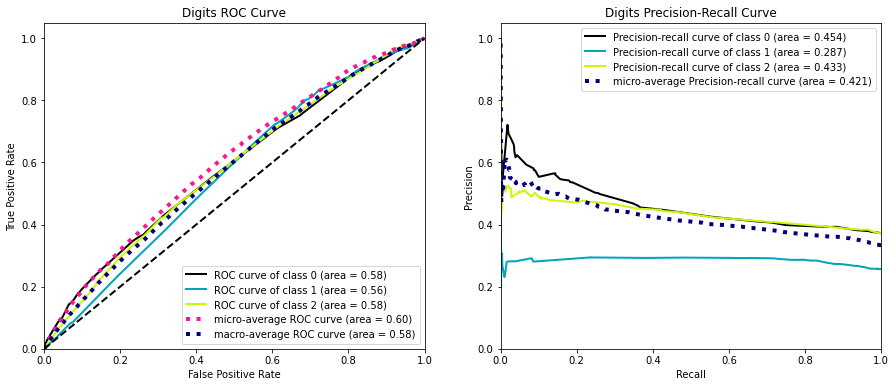

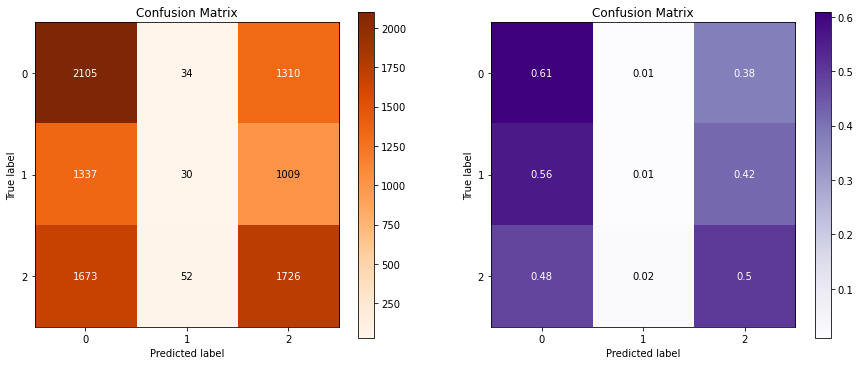

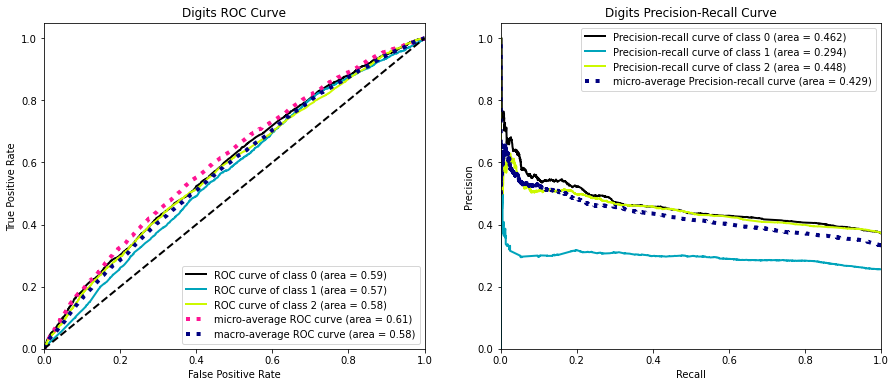

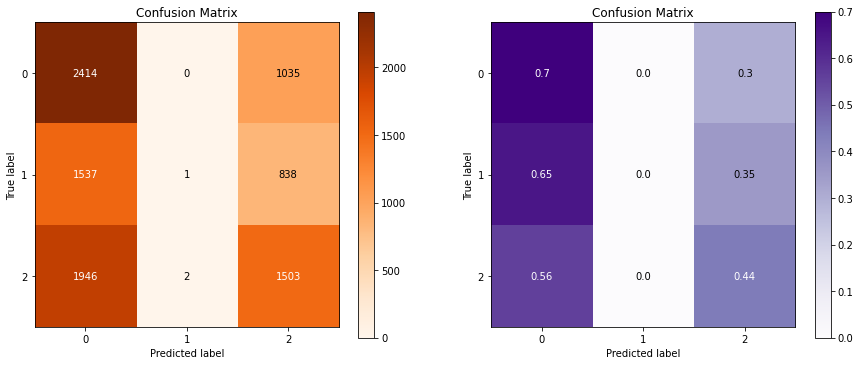

In [36]:
names = ["Logistic Regression", "Decision Tree", "Random Forest"]
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier

classifiers = [
    #KNeighborsClassifier(3),
    LogisticRegression(solver='sag', multi_class='auto', max_iter=1000, C=0.01),
    DecisionTreeClassifier(max_depth=7),
    RandomForestClassifier(max_depth=5, n_estimators=7, max_features=3),
]

for name, clf in zip(names, classifiers):
        #model = OneVsOneClassifier(clf).fit(X_train, y_train)
        model = clf.fit(X_train, y_train)
        prediction_in = model.predict(X_train)
        accuracy_r2_in = r2_score(y_train, prediction_in)
        prediction_out = model.predict(X_test)
        accuracy_r2_out = r2_score(y_test, prediction_out)
        print() 
        print(name) 
        print("-" * 20)
        print("Accuracy on training set: ",model.score(X_train, y_train))
        print("Accuracy on test set: ",model.score(X_test, y_test))
        ROC_PRC_matrix(model, y_test, X_test)
        confusion_matrix(model, y_test, X_test)


## Selected Best Model: 
- Random Forest with 7 trees and 5 depth, acc = 0.42238033635187583

## De encoding 


In [38]:
result_in = le.inverse_transform(prediction_in).tolist()
result_out = le.inverse_transform(prediction_out).tolist()
result = result_in + result_out

In [39]:
dataset_original['Predictions'] = result

In [40]:
dataset_original

,season,division,matchday,team,Away_team,index_match,W,L,T,result,rank,GD_home,GD_away,Predictions
9,1928-1929,1,2,Real Madrid,Barcelona,5,1.0,0.0,0.0,W,1.0,5.0,-5.0,W
7,1928-1929,1,2,Espanyol,Athletic,6,1.0,0.0,0.0,L,3.0,1.0,-1.0,L
8,1928-1929,1,2,Racing,Real Unión,8,0.0,1.0,0.0,L,9.0,-2.0,2.0,W
5,1928-1929,1,2,Arenas Club,Catalunya,9,0.0,1.0,0.0,L,7.0,-1.0,1.0,L
6,1928-1929,1,2,Athletic Madrid,Donostia,7,1.0,0.0,0.0,L,4.0,1.0,-1.0,L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47993,2021-2022,2,3,Girona,Ponferradina,48235,1.0,0.0,1.0,L,7.0,2.0,-2.0,L
47997,2021-2022,2,3,UD Almería,SD Amorebieta,48236,2.0,0.0,0.0,L,2.0,3.0,-3.0,W
47994,2021-2022,2,3,Real Valladolid,CD Lugo,48237,1.0,0.0,1.0,W,4.0,2.0,-2.0,L
47992,2021-2022,2,3,CF Fuenlabrada,Real Sociedad B,48238,1.0,1.0,0.0,T,10.0,1.0,-1.0,W
